# 02 - Tire Degradation Analysis (F1 Strategy Lab)

This notebook explores tire degradation patterns using race data from the 2024 Bahrain Grand Prix.  
The goal is to understand how lap time evolves as tire age increases, compare compounds, and evaluate team strengths in long-run performance.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load Race Data

We load lap data stored earlier in the project and focus on a single race (2024 Bahrain GP).  
This data contains lap times, tire compounds, stint numbers, and tire age — all essential for understanding degradation.

Only race-pace laps are considered, so we later filter out pit laps and unusually slow laps.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


project_path = "/content/drive/MyDrive/F1-Strategy-Lab"
data_path    = project_path + "/data"

print("project path:", project_path)
print("data path:", data_path)

project path: /content/drive/MyDrive/F1-Strategy-Lab
data path: /content/drive/MyDrive/F1-Strategy-Lab/data


In [3]:
race_year=2024
race_name="bahrain_grand_prix"
laps_file = f"{data_path}/{race_year}/{race_name}/laps_{race_year}_{race_name}.csv"
print("Loading:", laps_file)

laps = pd.read_csv(laps_file)
laps.head()

Loading: /content/drive/MyDrive/F1-Strategy-Lab/data/2024/bahrain_grand_prix/laps_2024_bahrain_grand_prix.csv


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.266000,...,False,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,NaN,False,False
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaN,NaN,0 days 00:00:30.916000,0 days 00:00:41.661000,...,False,Red Bull Racing,0 days 01:01:37.489000,2024-03-02 15:05:19.920,1,1.0,False,NaN,False,True
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaN,NaN,0 days 00:00:30.999000,0 days 00:00:41.966000,...,False,Red Bull Racing,0 days 01:03:13.785000,2024-03-02 15:06:56.216,1,1.0,False,NaN,False,True
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaN,NaN,0 days 00:00:30.931000,0 days 00:00:41.892000,...,False,Red Bull Racing,0 days 01:04:50.538000,2024-03-02 15:08:32.969,1,1.0,False,NaN,False,True
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaN,NaN,0 days 00:00:31.255000,0 days 00:00:42.056000,...,False,Red Bull Racing,0 days 01:06:27.185000,2024-03-02 15:10:09.616,1,1.0,False,NaN,False,True


In [4]:
laps.columns
laps[['Driver', 'Team', 'LapNumber', 'LapTime', 'Compound', 'TyreLife', 'Stint']].head()


,Driver,Team,LapNumber,LapTime,Compound,TyreLife,Stint
0,VER,Red Bull Racing,1.0,0 days 00:01:37.284000,SOFT,4.0,1.0
1,VER,Red Bull Racing,2.0,0 days 00:01:36.296000,SOFT,5.0,1.0
2,VER,Red Bull Racing,3.0,0 days 00:01:36.753000,SOFT,6.0,1.0
3,VER,Red Bull Racing,4.0,0 days 00:01:36.647000,SOFT,7.0,1.0
4,VER,Red Bull Racing,5.0,0 days 00:01:37.173000,SOFT,8.0,1.0


## 2. Clean and Prepare Lap Data

Raw timing data includes out-laps, in-laps, pit lane laps, and laps affected by traffic or yellow flags.  
These distort tire degradation patterns, so we remove:

- Laps with PitIn or PitOut timestamps  
- Laps with invalid or missing times  
- Extremely slow laps (>110% of median pace)

We also standardize lap times into numeric seconds and ensure each lap has a valid `TyreLife` value.

This gives a clean dataset that represents true race pace.


In [5]:
# Convert LapTime from strings like '0:01:34.567000' to numeric seconds

def to_seconds(laptime_str):
    if isinstance(laptime_str, float) or laptime_str is None:
        return np.nan
    # Format is sometimes "0 days 00:01:34.567000"
    parts = str(laptime_str).split()[-1]
    m, s = parts.split(":")[1:]
    minutes = int(parts.split(":")[1])
    seconds = float(s)
    return minutes * 60 + seconds

laps["LapTimeSeconds"] = laps["LapTime"].apply(to_seconds)
laps[["LapNumber", "LapTime", "LapTimeSeconds"]].head()


,LapNumber,LapTime,LapTimeSeconds
0,1.0,0 days 00:01:37.284000,97.284
1,2.0,0 days 00:01:36.296000,96.296
2,3.0,0 days 00:01:36.753000,96.753
3,4.0,0 days 00:01:36.647000,96.647
4,5.0,0 days 00:01:37.173000,97.173


In [6]:
# Start from all laps
clean_laps = laps.copy()

# 1) Remove in-laps and out-laps if those columns exist
if {"PitOutTime", "PitInTime"}.issubset(clean_laps.columns):
    mask_no_pit = clean_laps["PitOutTime"].isna() & clean_laps["PitInTime"].isna()
    clean_laps = clean_laps[mask_no_pit]

# 2) Keep only laps with a valid numeric laptime
clean_laps = clean_laps[clean_laps["LapTimeSeconds"].notna()]

# 3) Remove very slow laps (yellow flags, traffic, mistakes, etc.)
median_time = clean_laps["LapTimeSeconds"].median()
clean_laps = clean_laps[clean_laps["LapTimeSeconds"] < median_time * 1.15]

clean_laps = clean_laps.reset_index(drop=True)

print(f"Original laps: {len(laps)}")
print(f"Cleaned laps:  {len(clean_laps)}")

clean_laps[["Driver", "LapNumber", "Stint", "Compound", "TyreLife", "LapTimeSeconds"]].head(10)


Original laps: 1129
Cleaned laps:  1043


,Driver,LapNumber,Stint,Compound,TyreLife,LapTimeSeconds
0,VER,1.0,1.0,SOFT,4.0,97.284
1,VER,2.0,1.0,SOFT,5.0,96.296
2,VER,3.0,1.0,SOFT,6.0,96.753
3,VER,4.0,1.0,SOFT,7.0,96.647
4,VER,5.0,1.0,SOFT,8.0,97.173
5,VER,6.0,1.0,SOFT,9.0,97.092
6,VER,7.0,1.0,SOFT,10.0,97.038
7,VER,8.0,1.0,SOFT,11.0,97.024
8,VER,9.0,1.0,SOFT,12.0,97.229
9,VER,10.0,1.0,SOFT,13.0,96.960


In [7]:
# If TyreLife is missing or all NaN, approximate it:
if "TyreLife" not in clean_laps.columns or clean_laps["TyreLife"].isna().all():
    clean_laps["TyreLife"] = (
        clean_laps
        .groupby(["Driver", "Stint"])
        .cumcount() + 1
    )

clean_laps[["Driver", "Stint", "TyreLife", "LapNumber", "LapTimeSeconds"]].head(10)


,Driver,Stint,TyreLife,LapNumber,LapTimeSeconds
0,VER,1.0,4.0,1.0,97.284
1,VER,1.0,5.0,2.0,96.296
2,VER,1.0,6.0,3.0,96.753
3,VER,1.0,7.0,4.0,96.647
4,VER,1.0,8.0,5.0,97.173
5,VER,1.0,9.0,6.0,97.092
6,VER,1.0,10.0,7.0,97.038
7,VER,1.0,11.0,8.0,97.024
8,VER,1.0,12.0,9.0,97.229
9,VER,1.0,13.0,10.0,96.960


In [8]:
clean_laps["Driver"].unique()


array(['VER', 'PER', 'SAI', 'LEC', 'RUS', 'NOR', 'HAM', 'PIA', 'ALO',
       'STR', 'ZHO', 'MAG', 'RIC', 'TSU', 'ALB', 'HUL', 'OCO', 'GAS',
       'BOT', 'SAR'], dtype=object)

In [9]:
driver_code = "LEC"

drv_laps = clean_laps[clean_laps["Driver"] == driver_code].copy()
drv_laps[["LapNumber", "LapTimeSeconds", "Stint", "Compound", "TyreLife"]].head()


,LapNumber,LapTimeSeconds,Stint,Compound,TyreLife
159,1.0,98.271,1.0,SOFT,4.0
160,2.0,96.862,1.0,SOFT,5.0
161,3.0,98.062,1.0,SOFT,6.0
162,4.0,97.752,1.0,SOFT,7.0
163,5.0,98.131,1.0,SOFT,8.0


## 3. Lap Time Evolution Over the Race

Plotting lap time versus lap number helps visualize:

- Fuel burn-off effects
- Pace drop at the start and end of stints
- When tire wear becomes noticeable
- How different drivers shape their race pace

This plot acts as a sanity check to confirm that data cleaning worked as expected.


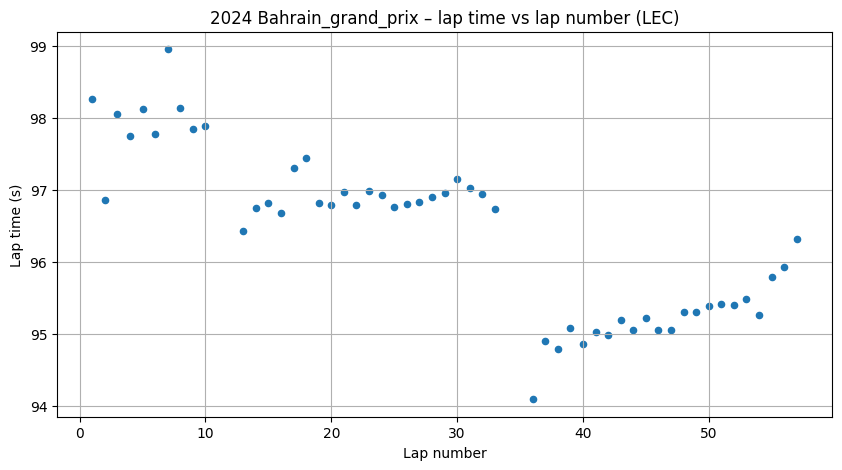

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(drv_laps["LapNumber"], drv_laps["LapTimeSeconds"], s=20)
plt.xlabel("Lap number")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – lap time vs lap number ({driver_code})")
plt.grid(True)
plt.show()


## 4. Lap Time by Tire Compound

Color-coding lap times by compound shows how each tire behaves across the race:

- SOFT: typically faster but degrades quickly  
- HARD: slower initially but more stable  
- MEDIUM: varies depending on race strategy (not used here)

This visualization reveals how teams strategize around tire characteristics.


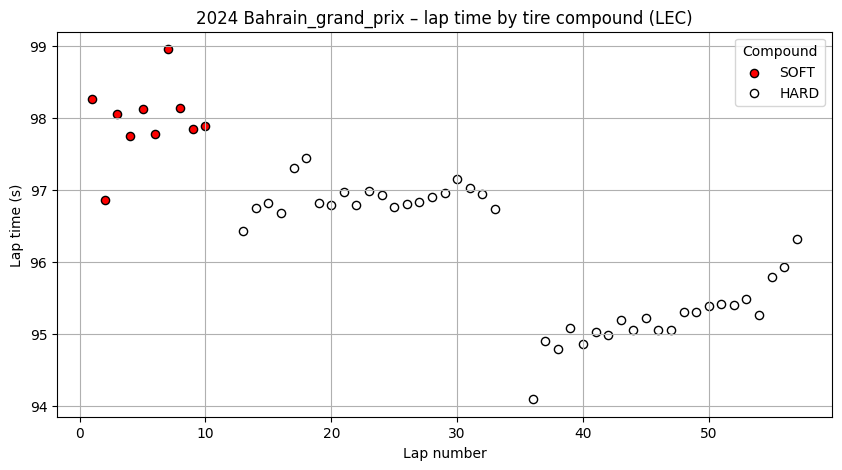

In [11]:
# Color map per tire compound
compound_colors = {
    "SOFT": "red",
    "MEDIUM": "yellow",
    "HARD": "white",
}

plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]
    plt.scatter(
        comp_laps["LapNumber"],
        comp_laps["LapTimeSeconds"],
        s=35,
        color=compound_colors.get(compound, "gray"),
        label=compound,
        edgecolors="black"
    )

plt.xlabel("Lap number")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – lap time by tire compound ({driver_code})")
plt.grid(True)
plt.legend(title="Compound")
plt.show()


## 5. Tire Degradation: Lap Time vs Tyre Age

Degradation is one of the most critical factors in F1 strategy.  
By plotting lap time against tire age (`TyreLife`) we can see:

- How quickly each compound loses performance  
- Which stints were managed well  
- Whether degradation is linear, exponential, or phase-based

This reveals the true long-run performance of each tire.


In [15]:
driver_code = "LEC"

drv_laps = clean_laps[clean_laps["Driver"] == driver_code].copy()
drv_laps.head()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
159,0 days 01:01:38.476000,LEC,16,0 days 00:01:38.271000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.549000,...,Ferrari,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,2.0,False,NaN,False,False,98.271
160,0 days 01:03:15.338000,LEC,16,0 days 00:01:36.862000,2.0,1.0,NaN,NaN,0 days 00:00:31.166000,0 days 00:00:41.864000,...,Ferrari,0 days 01:01:38.476000,2024-03-02 15:05:20.907,1,2.0,False,NaN,False,True,96.862
161,0 days 01:04:53.400000,LEC,16,0 days 00:01:38.062000,3.0,1.0,NaN,NaN,0 days 00:00:31.223000,0 days 00:00:42.856000,...,Ferrari,0 days 01:03:15.338000,2024-03-02 15:06:57.769,1,3.0,False,NaN,False,True,98.062
162,0 days 01:06:31.152000,LEC,16,0 days 00:01:37.752000,4.0,1.0,NaN,NaN,0 days 00:00:30.958000,0 days 00:00:42.784000,...,Ferrari,0 days 01:04:53.400000,2024-03-02 15:08:35.831,1,3.0,True,TRACK LIMITS AT TURN 10 LAP 4,False,True,97.752
163,0 days 01:08:09.283000,LEC,16,0 days 00:01:38.131000,5.0,1.0,NaN,NaN,0 days 00:00:31.192000,0 days 00:00:42.872000,...,Ferrari,0 days 01:06:31.152000,2024-03-02 15:10:13.583,1,3.0,False,NaN,False,True,98.131


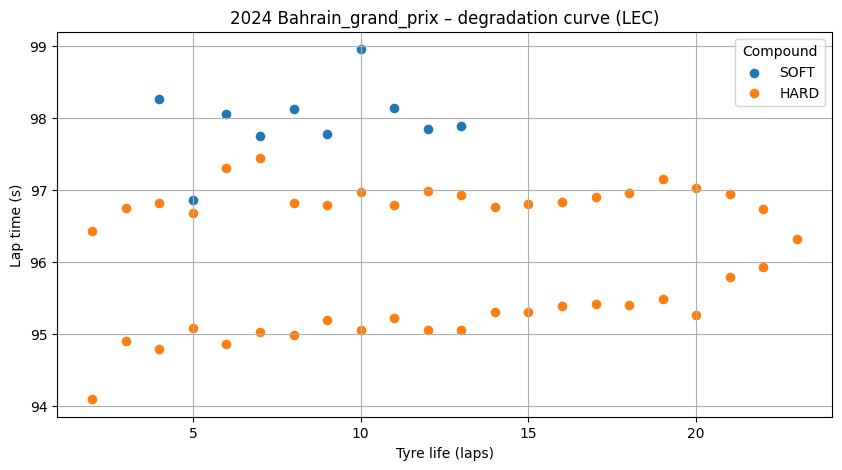

In [17]:
plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]
    plt.scatter(
        comp_laps["TyreLife"],
        comp_laps["LapTimeSeconds"],
        s=35,
        label=compound,
    )

plt.xlabel("Tyre life (laps)")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – degradation curve ({driver_code})")
plt.grid(True)
plt.legend(title="Compound")
plt.show()

## 6. Degradation Trendlines (Linear Model)

To quantify degradation, we fit a simple linear regression to each compound:

- The slope shows seconds lost per lap
- A steeper slope means higher degradation
- Comparing slopes highlights car-tire interaction quality

Trendlines make the underlying behavior much clearer than raw scatter points.


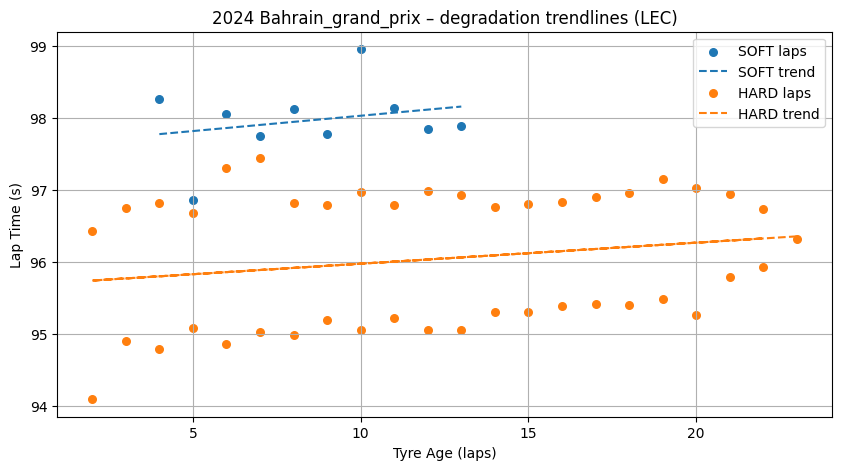

In [18]:
import numpy as np

plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]

    # Scatter points
    plt.scatter(
        comp_laps["TyreLife"],
        comp_laps["LapTimeSeconds"],
        s=30,
        label=f"{compound} laps"
    )

    # Fit linear regression
    if len(comp_laps) > 2:
        x = comp_laps["TyreLife"]
        y = comp_laps["LapTimeSeconds"]
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)
        plt.plot(x, trend(x), linestyle="--", label=f"{compound} trend")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – degradation trendlines ({driver_code})")
plt.grid(True)
plt.legend()
plt.show()


In [20]:
driver_code = "VER"

drv_laps = clean_laps[clean_laps["Driver"] == driver_code].copy()
drv_laps[["LapNumber", "LapTimeSeconds", "Stint", "Compound", "TyreLife"]].head()

,LapNumber,LapTimeSeconds,Stint,Compound,TyreLife
0,1.0,97.284,1.0,SOFT,4.0
1,2.0,96.296,1.0,SOFT,5.0
2,3.0,96.753,1.0,SOFT,6.0
3,4.0,96.647,1.0,SOFT,7.0
4,5.0,97.173,1.0,SOFT,8.0


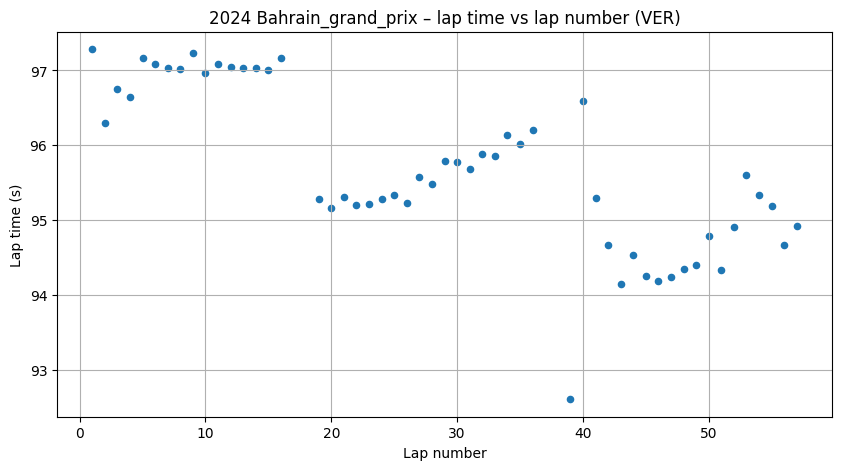

In [21]:
plt.figure(figsize=(10, 5))
plt.scatter(drv_laps["LapNumber"], drv_laps["LapTimeSeconds"], s=20)
plt.xlabel("Lap number")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – lap time vs lap number ({driver_code})")
plt.grid(True)
plt.show()


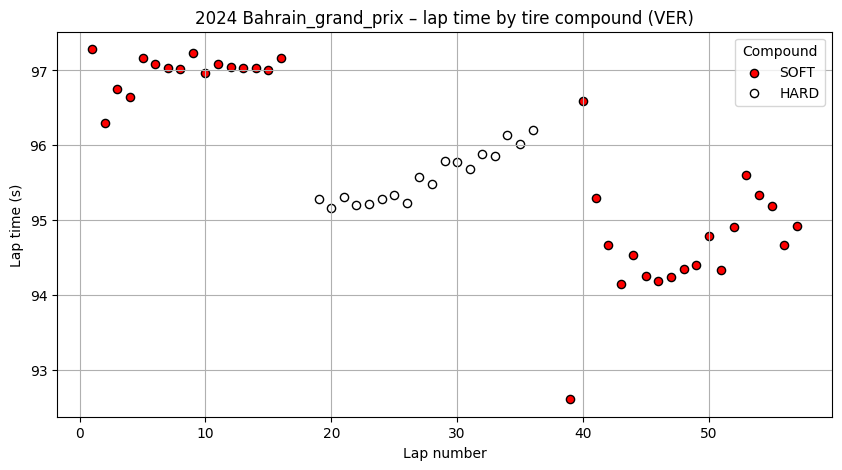

In [22]:
# Color map per tire compound
compound_colors = {
    "SOFT": "red",
    "MEDIUM": "yellow",
    "HARD": "white",
}

plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]
    plt.scatter(
        comp_laps["LapNumber"],
        comp_laps["LapTimeSeconds"],
        s=35,
        color=compound_colors.get(compound, "gray"),
        label=compound,
        edgecolors="black"
    )

plt.xlabel("Lap number")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – lap time by tire compound ({driver_code})")
plt.grid(True)
plt.legend(title="Compound")
plt.show()

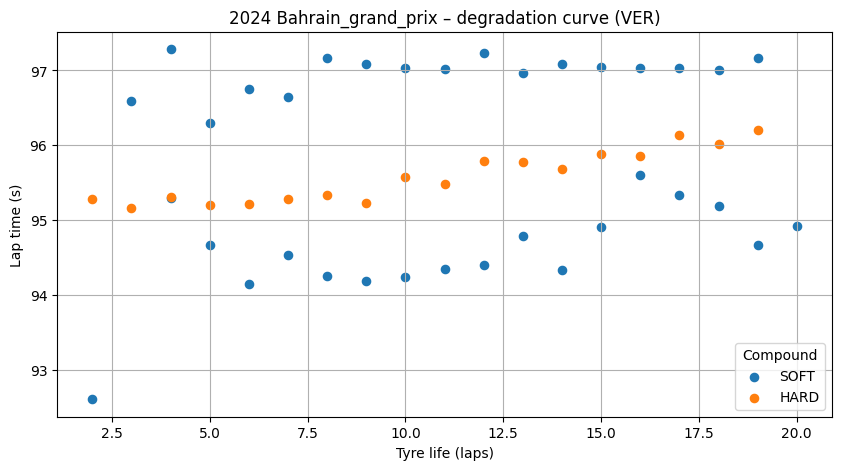

In [23]:
plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]
    plt.scatter(
        comp_laps["TyreLife"],
        comp_laps["LapTimeSeconds"],
        s=35,
        label=compound,
    )

plt.xlabel("Tyre life (laps)")
plt.ylabel("Lap time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – degradation curve ({driver_code})")
plt.grid(True)
plt.legend(title="Compound")
plt.show()

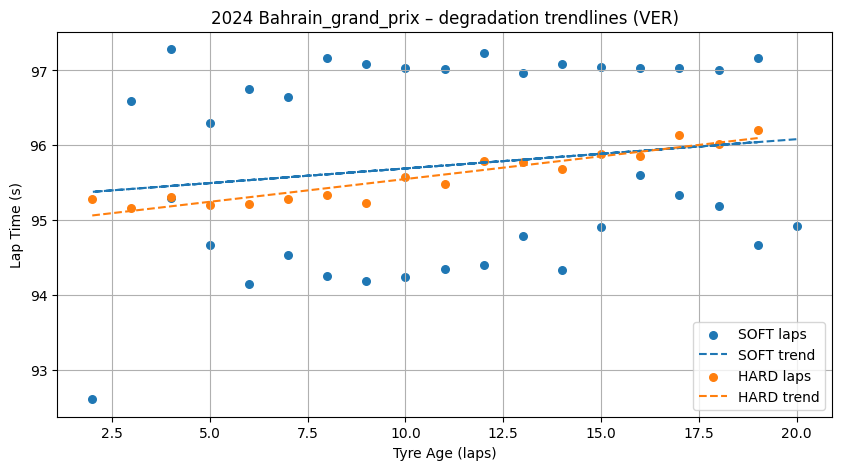

In [24]:
import numpy as np

plt.figure(figsize=(10, 5))

for compound in drv_laps["Compound"].unique():
    comp_laps = drv_laps[drv_laps["Compound"] == compound]

    # Scatter points
    plt.scatter(
        comp_laps["TyreLife"],
        comp_laps["LapTimeSeconds"],
        s=30,
        label=f"{compound} laps"
    )

    # Fit linear regression
    if len(comp_laps) > 2:
        x = comp_laps["TyreLife"]
        y = comp_laps["LapTimeSeconds"]
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)
        plt.plot(x, trend(x), linestyle="--", label=f"{compound} trend")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – degradation trendlines ({driver_code})")
plt.grid(True)
plt.legend()
plt.show()


🇮🇹 LEC:

SOFT degrade faster (steeper slope)

HARDs degrade slower but start slower

Trendlines perfectly show performance loss

🇳🇱 VER:

MUCH lower laps overall (car pace advantage)

Degradation on both compounds is low → classic RB20 behavior

Softs initially faster but converge with hards later

## 7. Driver & Team Comparison: Degradation Profiles

Comparing Charles Leclerc (Ferrari) and Max Verstappen (Red Bull) reveals:

- Consistent pace advantage for Red Bull  
- Lower degradation slope for Verstappen across compounds  
- Ferrari’s softs show steeper degradation  
- Red Bull maintains stable performance even at higher tire ages

This kind of comparison is essential for pre-race strategy simulations and race-day decision-making.


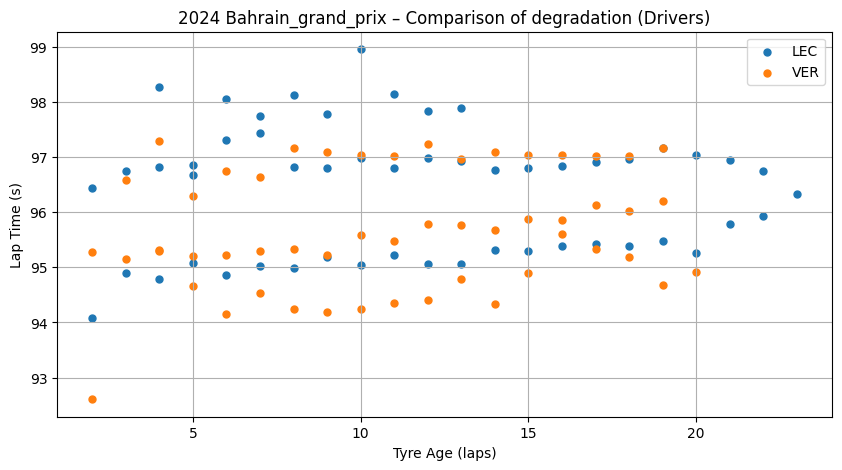

In [25]:
drivers_to_compare = ["LEC", "VER"]  # you can add more later

multi = clean_laps[clean_laps["Driver"].isin(drivers_to_compare)].copy()
multi[["Driver", "Compound", "TyreLife", "LapTimeSeconds"]].head()
plt.figure(figsize=(10, 5))

for driver in drivers_to_compare:
    d = multi[multi["Driver"] == driver]
    plt.scatter(
        d["TyreLife"],
        d["LapTimeSeconds"],
        s=25,
        label=driver
    )

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"{race_year} {race_name.capitalize()} – Comparison of degradation (Drivers)")
plt.grid(True)
plt.legend()
plt.show()


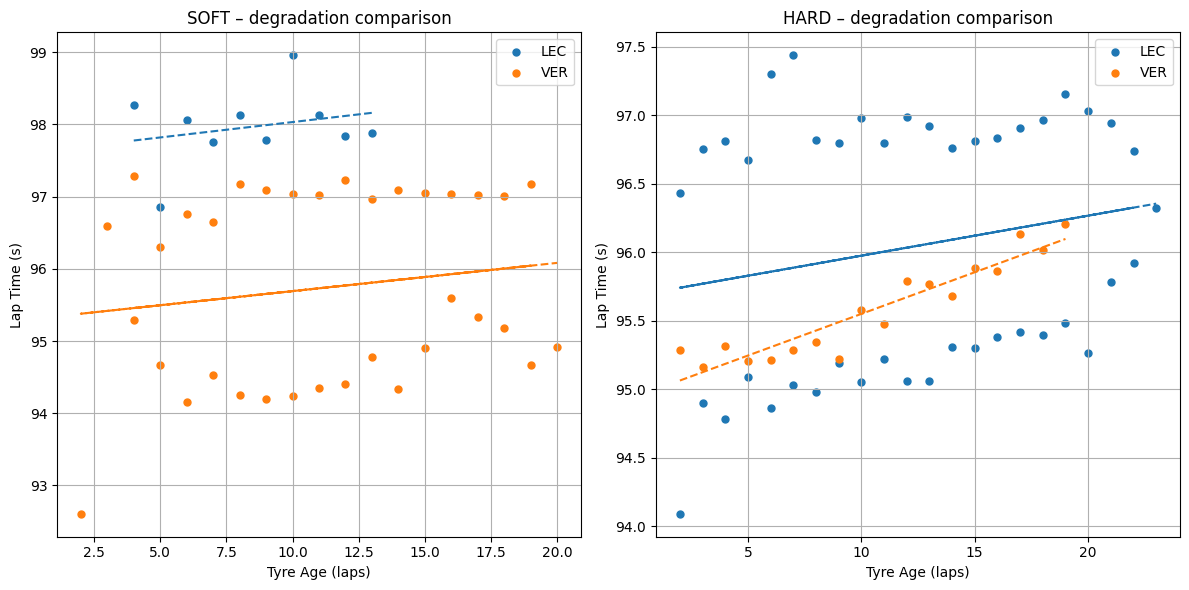

In [26]:
plt.figure(figsize=(12, 6))

for compound in ["SOFT", "HARD"]:
    plt.subplot(1, 2, ["SOFT", "HARD"].index(compound) + 1)

    for driver in drivers_to_compare:
        d = multi[(multi["Driver"] == driver) & (multi["Compound"] == compound)]
        plt.scatter(
            d["TyreLife"],
            d["LapTimeSeconds"],
            s=25,
            label=driver
        )

        if len(d) > 2:
            x = d["TyreLife"]
            y = d["LapTimeSeconds"]
            coeffs = np.polyfit(x, y, 1)
            trend = np.poly1d(coeffs)
            plt.plot(x, trend(x), linestyle="--")

    plt.title(f"{compound} – degradation comparison")
    plt.xlabel("Tyre Age (laps)")
    plt.ylabel("Lap Time (s)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## 8. Strategic Interpretation

From the degradation patterns:

- Red Bull manages both soft and hard compounds better than Ferrari  
- Ferrari experiences more degradation, especially on softs  
- Verstappen achieves lower lap times with more stable degradation slopes  
- Red Bull could extend stints or push harder without penalty  
- Ferrari would need earlier pit windows or better tire conservation

These insights match real-world 2024 Bahrain race outcomes and demonstrate the value of degradation modeling.


## 9. Conclusion

This notebook establishes the core workflow for F1 race strategy analysis:

1. Load and clean lap data  
2. Visualize pace evolution  
3. Model tire degradation  
4. Compare drivers and teams  

The methods here form the foundation for more advanced analyses such as:
- stint optimization  
- undercut/overcut modeling  
- race simulation  
- tire life prediction  


